# !!!NOTE!!! Every time the model is trained it will produced a difference forecast. So no need to save the model again :)

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf

# Dealing with temporal data
from typing import Dict, List, Tuple, Sequence

# Tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2023-03-14 15:07:49.852576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.getcwd()

csv_path = os.path.join('..', 'inflation-forecasting', 'raw_data')

df = pd.read_csv(os.path.join(csv_path,'data_final.csv'), index_col=0)

In [3]:
df['year'] = pd.to_datetime(df['year'])

In [4]:
df = df[df['country_id'] == "NL"]

<Axes: >

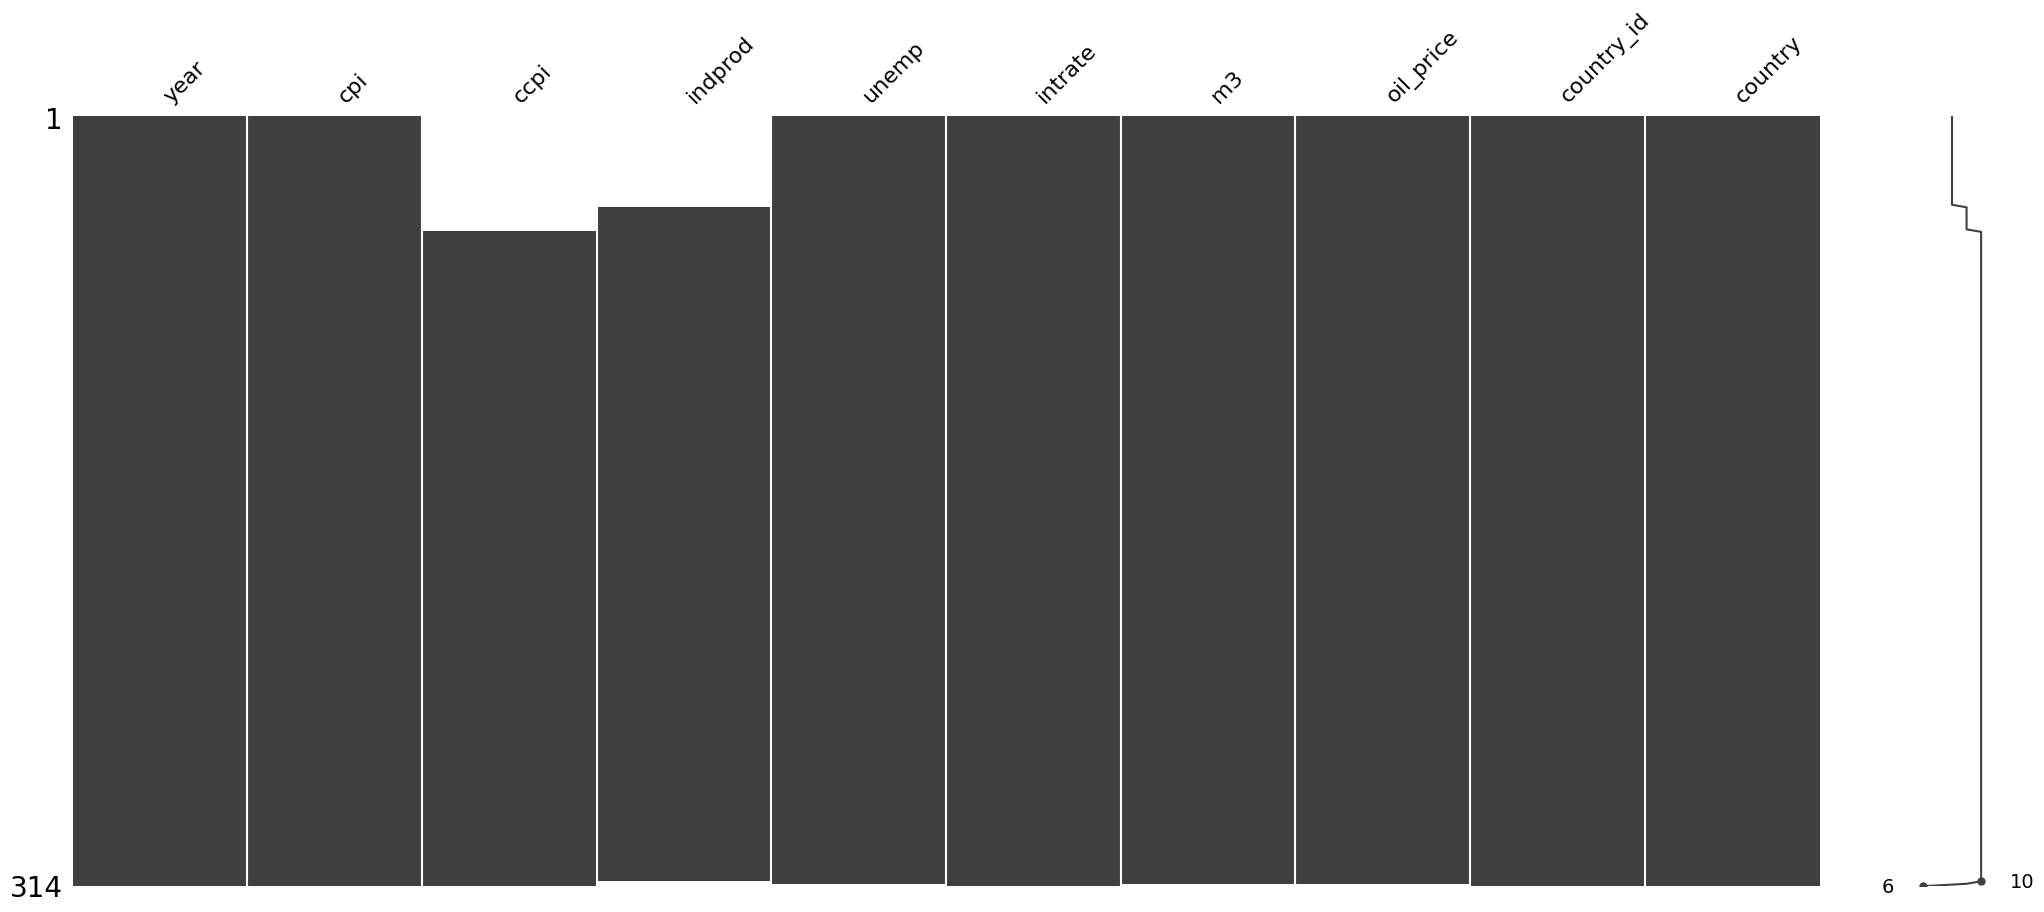

In [6]:
import missingno as msno
msno.matrix(df)

In [7]:
df.shape

(314, 10)

In [30]:
df = df.dropna(subset=['ccpi'])

In [31]:
ccpi = pd.DataFrame(df['ccpi'])

In [32]:
ccpi = ccpi.to_numpy()

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

In [34]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [35]:
n_steps_in = 12

data = dataset[0:]

X, Y = split_sequence(data, n_steps_in)

In [36]:
X.shape

(255, 12, 1)

In [37]:
n_features = X.shape[2]

uni_model = models.Sequential()
uni_model.add(LSTM(64,
                   activation = 'relu',
                   input_shape = (X.shape[1], n_features)))
uni_model.add(Dense(1, 
                    activation='linear'))

In [38]:
n_features = X.shape[2]

uni_model = models.Sequential()
uni_model.add(LSTM(64, input_shape=(X.shape[1], n_features))) # Adding the LSTM layer
uni_model.add(Dense(1))

In [ ]:
adam = optimizers.Adam(learning_rate=0.02) 

uni_model.compile(loss='mse', 
                  optimizer=adam, 
                  metrics=["mse"])

fit = uni_model.fit(X, 
                    Y,   
                    epochs = 25, 
                    batch_size=1,
                    verbose = 1)

Epoch 1/25
255/255 [==============================] - 4s 4ms/step - loss: 0.0096 - mse: 0.0096
Epoch 2/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 3/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 4/25
255/255 [==============================] - 1s 5ms/step - loss: 0.0041 - mse: 0.0041
Epoch 5/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 6/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 7/25
255/255 [==============================] - 1s 5ms/step - loss: 0.0051 - mse: 0.0051
Epoch 8/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 9/25
255/255 [==============================] - 1s 6ms/step - loss: 0.0053 - mse: 0.0053
Epoch 10/25
255/255 [==============================] - 1s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 11/25
255/255 [============================

In [ ]:
# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
#plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show

In [ ]:
Predict = uni_model.predict(X)

Y_hat = scaler.inverse_transform(Predict)

Y_actual = scaler.inverse_transform(Y)

In [ ]:
data1 = pd.DataFrame(Y_actual)
data2 = pd.DataFrame(Y_hat)

In [ ]:
plt.plot(data1)
plt.plot(data2);

In [ ]:
n_steps_in = 12
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))
forecast_normalized = uni_model.predict(x_input)
forecast = scaler.inverse_transform(forecast_normalized)

In [ ]:
pd.DataFrame(forecast)

In [ ]:
# Make a prediction
# Append the predition
# Shift the data
# Fit the model again
# Repeat ...
# Normalize invert

In [ ]:
def future_forecasting(dataset, model, mb=12, mf=12):
    '''
    Returns the future forecasting of the model. Please select the dataset and model you want to use.
    for mb, select the number of months you want to look back to make a prediction. 
    for mf, select the number of months you want the prediction to look forward.
    '''
    results = []
    x_input = dataset[-mb:].reshape(1, mb, 1)
    for num in range(mf):
        forecast = model.predict(x_input)
        results.append(forecast[0][0])
        x_input = np.roll(x_input, -1, axis=1)
        x_input[0][-1] = forecast
    results = scaler.inverse_transform(np.array(results).reshape(-1, 1)) # reshape dataset to 2D array
    return results

In [ ]:
test = future_forecasting(dataset,uni_model,mb=12,mf=24)
test

In [ ]:
pd.DataFrame(test).plot()

# Save the model for the US

In [29]:
uni_model.save("model_nl_ccpi.h5")